# Train a linear regressor with more features.

Following the OligoMiner papar we reina a linar regression model with only the length, the gc content and the alignement score. However the reults obtained are very poor since it is oly slightly better that simply predictiong the average. To solve this we add a 1-hot encoding of the sequence to the previous setting to have more features to learn from.

In [1]:
oligo_length_max = 35
import os
import sys
import copy
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from torch.utils import data
from torch import nn
from torch import optim
import torch

from typing import Tuple
import time

from oligo_seq.database import *
from oligo_seq.models import *


def train_epoch(model: nn.Module, dataloader: data.DataLoader, loss: nn.Module, optimizer: optim.Optimizer, device: torch.device) -> float:
    model.train()
    cumulative_loss = torch.zeros(1,).to(device)
    for batch in dataloader:
        batch_device = []
        for t in batch:
            batch_device.append(t.to(device))
        data = batch_device[:-1]
        label = batch_device[-1]
        pred = model(*data)
        batch_loss = loss(pred, label)
        cumulative_loss += batch_loss
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    loss = cumulative_loss/len(dataloader)
    return loss.item()


def eval_epoch(model: nn.Module, dataloader: data.DataLoader, loss: nn.Module, device: torch.device) -> float:
    model.eval()
    cumulative_loss = torch.zeros(1,).to(device)
    with torch.no_grad():
        for batch in dataloader:
            batch_device = []
            for t in batch:
                batch_device.append(t.to(device))
            data = batch_device[:-1]
            label = batch_device[-1]
            pred = model(*data)
            cumulative_loss += loss(pred, label)
    loss = cumulative_loss/len(dataloader)
    return loss.item()

(1755, 287)
L2 loss with the second gt: 8.385172924528684, R2 score: 0.8831434307003854


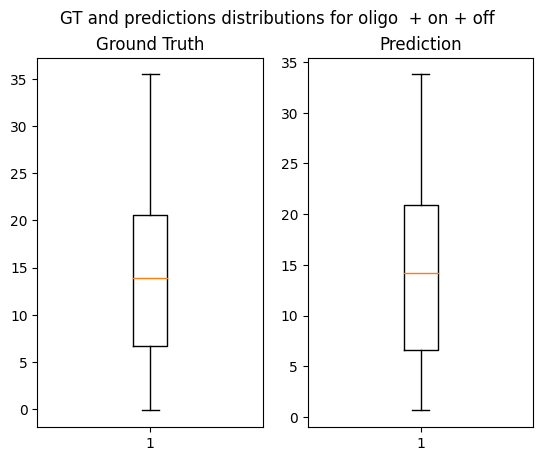

Text(0.5, 1.0, 'Correlation of GT and predictions')

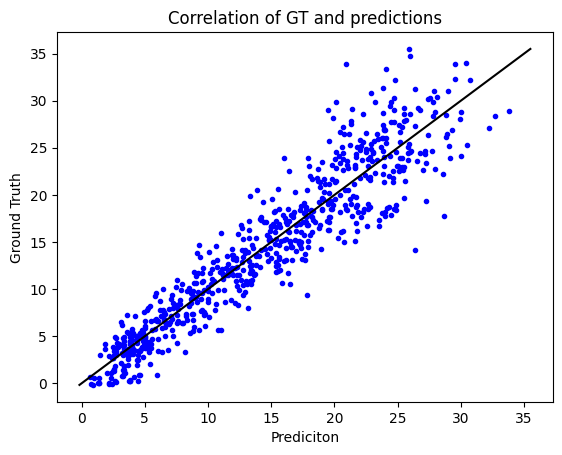

In [ ]:
def one_hot_encoding(sequence: str, oligo_length_max: str):
    sequence_encoding = np.zeros(4*oligo_length_max)
    for i, nt in enumerate(sequence):
        #encoding order is A, T, C. G
        if nt == 'A' or nt == 'a':
            nt_encoding = [1,0,0,0]
        elif nt == 'C' or nt == 'c':
            nt_encoding = [0,1,0,0]
        elif nt == 'G' or nt == 'g':
            nt_encoding = [0,0,1,0]
        elif nt == 'T' or nt == 't':
            nt_encoding = [0,0,0,1]
        else:
            Warning(f"Nucleotide {nt} not recognized.")
        sequence_encoding[4*i:4*(i+1)] = nt_encoding
    return sequence_encoding

def n_mismatches(strand_1, strand_2):
    mismatches = 0
    for i in range(len(strand_1)):
        if strand_1[i] != strand_2[i]:
            mismatches += 1
    return mismatches

# create datset with relevant features
dir_synthetic_dataset = os.path.join("output_artificial", "synthetic_dataset")
dataset = pd.read_csv(os.path.join(dir_synthetic_dataset, "synthetic_dataset.csv"), index_col=0 )
X = np.zeros((len(dataset), 2*(oligo_length_max*4) + 7)) # one-hot encoding of the two sequences and the additional features
for i, row in dataset.iterrows(): # teh dataset indices are ordered
    oligo_encoding = one_hot_encoding(row["oligo_sequence"], oligo_length_max=oligo_length_max)
    off_target_encoding = one_hot_encoding(row["off_target_sequence"], oligo_length_max=oligo_length_max) # what is the real max length?
    mismatches = np.array([n_mismatches(row["oligo_sequence"], row["off_target_sequence"])])
    X[i,:] = np.concatenate([oligo_encoding, off_target_encoding, row[["oligo_length", "oligo_GC_content", "off_target_legth", "off_target_GC_content","tm_diff", "number_mismatches"]].to_numpy(), mismatches])
print(X.shape)


# train a linear model
y = dataset["duplexing_log_score"]

# X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size = 0.4, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)

# model1 = LinearRegression()
# model1.fit(X_train, y1_train)
# y1_pred = model1.predict(X_test)
# loss1 = mean_squared_error(y1_test, y1_pred)
# r2_1 = model1.score(X_test, y1_test)
# print(f"L2 loss with the first gt: {loss1}, R2 score: {r2_1}")

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
loss= mean_squared_error(y_test, y_pred)
r2 = model.score(X_test, y_test)
print(f"L2 loss with the second gt: {loss}, R2 score: {r2}")

# compare the distributions
# fig = plt.figure()
# fig.suptitle("GT and predictions distributions for oligo  + off")
# axes = fig.subplots(1, 2)
# axes[0].boxplot(y1_test)
# axes[0].set_title("Ground Truth")
# axes[1].boxplot(y1_pred)
# axes[1].set_title("Prediction")
# plt.show()

fig = plt.figure()
fig.suptitle("GT and predictions distributions for oligo  + on + off")
axes = fig.subplots(1, 2)
axes[0].boxplot(y_test)
axes[0].set_title("Ground Truth")
axes[1].boxplot(y_pred)
axes[1].set_title("Prediction")
plt.show()


# coorelation plots
# plt.plot(y1_pred, y1_test, "r.", label="oligo + off")
plt.plot(y_pred, y_test, "b.", label="oligo + on + off")
x = np.linspace(y_test.min(), y_test.max(), 1000)
plt.plot(x, x, 'k-')
plt.xlabel("Prediciton")
plt.ylabel("Ground Truth")
plt.title("Correlation of GT and predictions")


# Train an MLP

to further add complexity we train an MLP on the same dataset as before to investigate whether it is possible to learn more information.

Device in use: cpu
********** 	 MLP TRAINING 	 **********
Epoch 1: 	 Train Loss: 0.16039805114269257, 	 Validation Loss: 0.13827025890350342, Computation time : 1.5391180515289307
Epoch 2: 	 Train Loss: 0.13265034556388855, 	 Validation Loss: 0.12963877618312836, Computation time : 1.5035009384155273
Epoch 3: 	 Train Loss: 0.12220259010791779, 	 Validation Loss: 0.12178391963243484, Computation time : 1.4926939010620117
Epoch 4: 	 Train Loss: 0.1146051436662674, 	 Validation Loss: 0.11735890060663223, Computation time : 1.5088520050048828
Epoch 5: 	 Train Loss: 0.10831433534622192, 	 Validation Loss: 0.11333753168582916, Computation time : 1.486410140991211
Epoch 6: 	 Train Loss: 0.10286673903465271, 	 Validation Loss: 0.1112247183918953, Computation time : 1.5009841918945312
Epoch 7: 	 Train Loss: 0.09833402186632156, 	 Validation Loss: 0.10759514570236206, Computation time : 1.5882601737976074
Epoch 8: 	 Train Loss: 0.09452944248914719, 	 Validation Loss: 0.1099071353673935, Computat

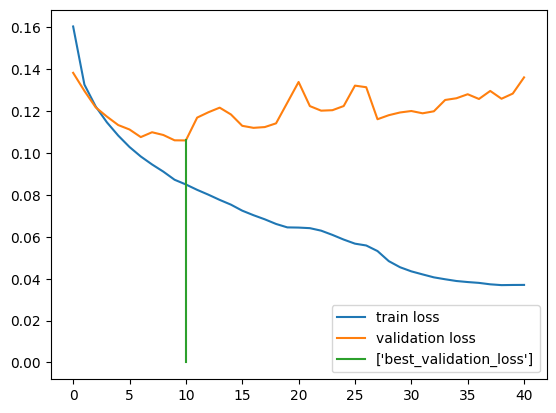

In [29]:
# hyper parameters
n_layers = 3
hidden_size= 256 # the number of layers is inferred from this (out_dim = 1 always)
batch_size = 128
lr = 1e-3
n_epochs = 1000
max_patience = 30

device = torch.device("cuda") if torch.cuda.is_available() is True else torch.device("cpu")
print(f"Device in use: {device}")

# dataset and dataloader
dataset = MLPDataset(path="/Users/francesco/Documents/Work/Oligo/Pombo-voucher/data/datasets/artificial_dataset_35_35.csv")
train, validation, test = data.random_split(dataset=dataset, lengths=[0.4, 0.2, 0.4], generator=torch.Generator().manual_seed(42))
train_loader = data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
validation_loader = data.DataLoader(dataset=validation, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

# model
mlp = OligoMLP(input_size=oligo_length_max*8+6, hidden_size=hidden_size, n_layers=n_layers).to(device)

# optimizer
optimizer = optim.Adam(mlp.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=15)
loss = nn.MSELoss()

# training
train_losses = []
validation_losses = []
print(f"********** \t MLP TRAINING \t **********")
best_validation_loss = None
best_model = mlp.state_dict()
patience = 0
epoch_best_model = 0
for i in range(n_epochs):
    start = time.time()
    train_loss = train_epoch(model=mlp, dataloader=train_loader, loss=loss, optimizer=optimizer, device=device)
    train_losses.append(train_loss)
    validation_loss = eval_epoch(model=mlp, dataloader=validation_loader, loss=loss, device=device)
    validation_losses.append(validation_loss)
    scheduler.step(validation_loss)
    if best_validation_loss is None or validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        # patience reset 
        best_model = mlp.state_dict()
        epoch_best_model = i
        patience = 0
    else:
        # patience update
        patience += 1
    if patience >= max_patience:
        #restore teh best model
        mlp.load_state_dict(best_model)
        break
    print(f"Epoch {i+1}: \t Train Loss: {train_loss}, \t Validation Loss: {validation_loss}, Computation time : {time.time() - start}")

print(f"\nBest validation loss: {best_validation_loss}")
x = list(range(len(train_losses)))
plt.plot(x, train_losses, label="train loss")
plt.plot(x, validation_losses, label="validation loss")
plt.plot([epoch_best_model, epoch_best_model], [0, best_validation_loss], label=["best_validation_loss"])
plt.legend()
plt.show()


## MLP performance analysis

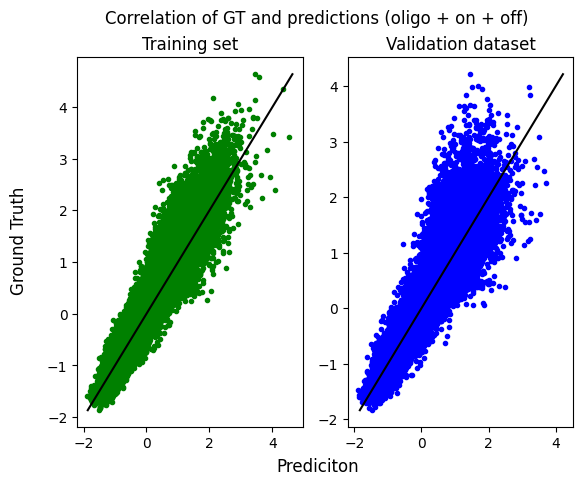

In [30]:
import numpy as np

# correlation plots
for i, (data, labels) in enumerate(train_loader):
    if i == 0:
        labels_train = labels
        preds_train = mlp(data)
    else:
        labels_train = torch.cat([labels_train, labels])
        preds_train = torch.cat([preds_train, mlp(data)])

for i, (data, labels) in enumerate(validation_loader):
    if i == 0:
        labels_validation = labels
        preds_validation = mlp(data)
    else:
        labels_validation = torch.cat([labels_validation, labels])
        preds_validation = torch.cat([preds_validation, mlp(data)])

fig = plt.figure()
axes = fig.subplots(1,2)
axes[0].plot(preds_train.detach(), labels_train.detach(), "g.")
axes[0].set_title("Training set")
x = np.linspace(labels_train.min().item(), labels_train.max().item(), 1000)
axes[0].plot(x, x, 'k-')
axes[1].plot(preds_validation.detach(), labels_validation.detach(), "b.")
axes[1].set_title("Validation dataset")
x = np.linspace(labels_validation.min().item(), labels_validation.max().item(), 1000)
axes[1].plot(x, x, 'k-')
fig.supxlabel("Prediciton")
fig.supylabel("Ground Truth")
fig.suptitle("Correlation of GT and predictions (oligo + on + off)")
plt.show()

# RNN approach
Feed the strands as a sequence one nucleotide at a time to a recurrent neural network

pythorch natively supports also varying lenght sequences via the PackedSequence class that is returned by the data loader


In [4]:
# train the model
import os
import matplotlib.pyplot as plt
import time

# hyperparameters
input_size = 8
features_size = 6
n_layers = 1
hidden_size = 128
lr=1e-3
n_epochs = 1000
batch_size=128
max_patience = 30

device = torch.device("cuda") if torch.cuda.is_available() is True else torch.device("cpu")
print(f"Device in use: {device}")

# dataset, model, optimizer iniitialization
dataset = RNNDataset(path="/Users/francesco/Documents/Work/Oligo/Pombo-voucher/data/datasets/artificial_dataset_35_35.csv")
train, validation, test = torch.utils.data.random_split(dataset=dataset, lengths=[0.4, 0.2, 0.4], generator=torch.Generator().manual_seed(1234))
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True, collate_fn=pack_collate)
validation_loader = torch.utils.data.DataLoader(dataset=validation, batch_size=batch_size, shuffle=False, collate_fn=pack_collate)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False, collate_fn=pack_collate)



rnn = OligoRNN(input_size=input_size, features_size=features_size, hidden_size=hidden_size, n_layers=n_layers).to(device)

optimizer = torch.optim.Adam(params=rnn.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=5)
loss = torch.nn.MSELoss()

# train the model
train_losses = []
validation_losses = []
print(f"********** \t RNN TRAINING \t **********")
best_validation_loss = None
best_model = rnn.state_dict()
patience = 0
epoch_best_model = 0
for i in range(n_epochs):
    start = time.time()
    train_loss = train_epoch(model=rnn, dataloader=train_loader, loss=loss, optimizer=optimizer, device=device)
    train_losses.append(train_loss)
    validation_loss = eval_epoch(model=rnn, dataloader=validation_loader, loss=loss, device=device)
    validation_losses.append(validation_loss)
    scheduler.step(validation_loss)
    if best_validation_loss is None or validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        # patience reset 
        best_model = copy.deepcopy(rnn.state_dict())
        epoch_best_model = i
        patience = 0
    else:
        # patience update
        patience += 1
    if patience >= max_patience:
        #restore teh best model
        rnn.load_state_dict(best_model)
        break
    print(f"Epoch {i+1}: \t Train Loss: {train_loss}, \t Validation Loss: {validation_loss},  Computation time : {time.time() - start}")

print(f"\nBest validation loss: {best_validation_loss}")
x = list(range(len(train_losses)))
plt.plot(x, train_losses, label="train loss")
plt.plot(x, validation_losses, label="validation loss")
plt.plot([epoch_best_model, epoch_best_model], [0, best_validation_loss], label=["best_validation_loss"])
plt.legend()
plt.show()




Device in use: cpu
********** 	 RNN TRAINING 	 **********
Epoch 1: 	 Train Loss: 0.17930825054645538, 	 Validation Loss: 0.10196125507354736,  Computation time : 19.107874631881714
Epoch 2: 	 Train Loss: 0.10478319972753525, 	 Validation Loss: 0.09339813143014908,  Computation time : 20.069764852523804
Epoch 3: 	 Train Loss: 0.09318818897008896, 	 Validation Loss: 0.08528686314821243,  Computation time : 19.805500268936157
Epoch 4: 	 Train Loss: 0.08896525949239731, 	 Validation Loss: 0.08356311172246933,  Computation time : 20.230167865753174
Epoch 5: 	 Train Loss: 0.08379015326499939, 	 Validation Loss: 0.0849137008190155,  Computation time : 19.777172327041626
Epoch 6: 	 Train Loss: 0.08040276914834976, 	 Validation Loss: 0.07648040354251862,  Computation time : 20.859983921051025
Epoch 7: 	 Train Loss: 0.07652159780263901, 	 Validation Loss: 0.07837551832199097,  Computation time : 19.788345098495483
Epoch 8: 	 Train Loss: 0.07472870498895645, 	 Validation Loss: 0.08721328526735306

KeyboardInterrupt: 

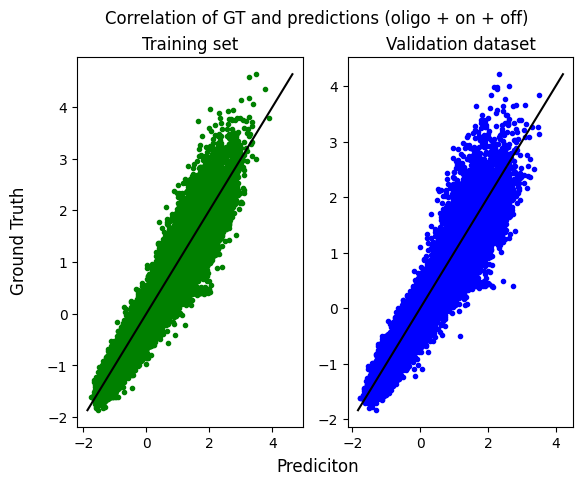

In [6]:
import numpy as np

# correlation plots
for i, (sequences, features, labels) in enumerate(train_loader):
    if i == 0:
        labels_train = labels
        preds_train = rnn(sequences, features)
    else:
        labels_train = torch.cat([labels_train, labels])
        preds_train = torch.cat([preds_train, rnn(sequences, features)])

for i, (sequences, features, labels) in enumerate(validation_loader):
    if i == 0:
        labels_validation = labels
        preds_validation = rnn(sequences, features)
    else:
        labels_validation = torch.cat([labels_validation, labels])
        preds_validation = torch.cat([preds_validation, rnn(sequences, features)])

fig = plt.figure()
axes = fig.subplots(1,2)
axes[0].plot(preds_train.detach(), labels_train.detach(), "g.")
axes[0].set_title("Training set")
x = np.linspace(labels_train.min().item(), labels_train.max().item(), 1000)
axes[0].plot(x, x, 'k-')
axes[1].plot(preds_validation.detach(), labels_validation.detach(), "b.")
axes[1].set_title("Validation dataset")
x = np.linspace(labels_validation.min().item(), labels_validation.max().item(), 1000)
axes[1].plot(x, x, 'k-')
fig.supxlabel("Prediciton")
fig.supylabel("Ground Truth")
fig.suptitle("Correlation of GT and predictions (oligo + on + off)")
plt.show()

## LSTM

The Recurrent networks are more suitable for this kind of data than a simple MLP and ca achieve better performances in a Vanilla implementation already. On this regard we try to implement more complex and avanced implementations suche as LSTM, which have shown better performances at propagating information throughout throughout the whole sequences and have less problems of exploding and vanishing gradients.

In [7]:
# train the model
import os
import matplotlib.pyplot as plt
import time


# hyperparameters
input_size = 8
features_size = 6
hidden_size = 64
lr=1e-3
n_epochs = 1000
batch_size=128
max_patience = 30

# dataset, model, optimizer iniitialization
dataset = RNNDataset(path="/Users/francesco/Documents/Work/Oligo/Pombo-voucher/data/datasets/artificial_dataset_15_100.csv")
train, validation, test = torch.utils.data.random_split(dataset=dataset, lengths=[0.4, 0.2, 0.4], generator=torch.Generator().manual_seed(42))
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True, collate_fn=pack_collate)
validation_loader = torch.utils.data.DataLoader(dataset=validation, batch_size=batch_size, shuffle=False, collate_fn=pack_collate)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False, collate_fn=pack_collate)

device = torch.device("cuda") if torch.cuda.is_available() is True else torch.device("cpu")
print(f"Device in use: {device}")

lstm = OligoLSTM(input_size=input_size, features_size=features_size, hidden_size=hidden_size, n_layers=1).to(device)

optimizer = torch.optim.Adam(params=lstm.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=5)
loss = torch.nn.MSELoss()

# train the model
train_losses = []
validation_losses = []
print(f"********** \t LSTM TRAINING \t **********")
best_validation_loss = None
best_model = lstm.state_dict()
patience = 0
epoch_best_model = 0
for i in range(n_epochs):
    start = time.time()
    train_loss = train_epoch(model=lstm, dataloader=train_loader, loss=loss, optimizer=optimizer, device=device)
    train_losses.append(train_loss)
    validation_loss = eval_epoch(model=lstm, dataloader=validation_loader, loss=loss, device=device)
    validation_losses.append(validation_loss)
    scheduler.step(validation_loss)
    if best_validation_loss is None or validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        # patience reset 
        best_model = copy.deepcopy(lstm.state_dict())
        epoch_best_model = i
        patience = 0
    else:
        # patience update
        patience += 1
    if patience >= max_patience:
        #restore teh best model
        lstm.load_state_dict(best_model)
        break
    print(f"Epoch {i+1}: \t Train Loss: {train_loss}, \t Validation Loss: {validation_loss}, Computation time : {time.time() - start}")

print(f"\nBest validation loss: {best_validation_loss}")
x = list(range(len(train_losses)))
plt.plot(x, train_losses, label="train loss")
plt.plot(x, validation_losses, label="validation loss")
plt.plot([epoch_best_model, epoch_best_model], [0, best_validation_loss], label=["best_validation_loss"])
plt.legend()
plt.show()




Device in use: cpu
********** 	 LSTM TRAINING 	 **********
Epoch 1: 	 Train Loss: 0.17175208032131195, 	 Validation Loss: 0.10926903784275055, Computation time : 26.94214391708374
Epoch 2: 	 Train Loss: 0.1046910360455513, 	 Validation Loss: 0.09338857233524323, Computation time : 26.77707290649414
Epoch 3: 	 Train Loss: 0.09158485382795334, 	 Validation Loss: 0.0823185071349144, Computation time : 26.874171257019043
Epoch 4: 	 Train Loss: 0.08467786759138107, 	 Validation Loss: 0.08178195357322693, Computation time : 33.33178210258484
Epoch 5: 	 Train Loss: 0.08070112764835358, 	 Validation Loss: 0.07830203324556351, Computation time : 33.514867067337036
Epoch 6: 	 Train Loss: 0.0776544138789177, 	 Validation Loss: 0.07431171089410782, Computation time : 37.01284408569336
Epoch 7: 	 Train Loss: 0.07496786117553711, 	 Validation Loss: 0.07380209118127823, Computation time : 51.398340940475464
Epoch 8: 	 Train Loss: 0.0728907510638237, 	 Validation Loss: 0.07123973220586777, Computation

KeyboardInterrupt: 

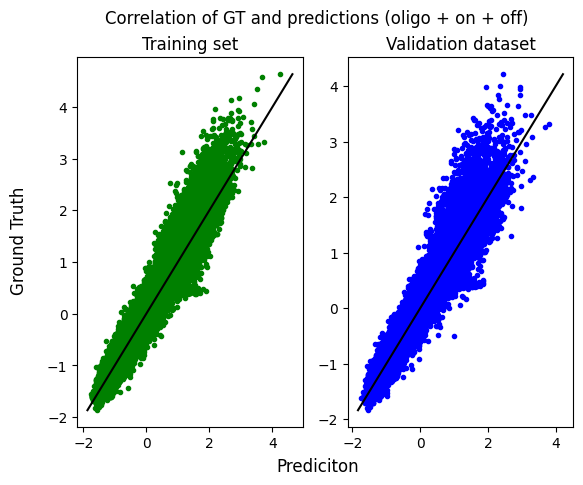

In [8]:
import numpy as np

# correlation plots
for i, (sequences, features, labels) in enumerate(train_loader):
    if i == 0:
        labels_train = labels
        preds_train = lstm(sequences, features)
    else:
        labels_train = torch.cat([labels_train, labels])
        preds_train = torch.cat([preds_train, lstm(sequences, features)])

for i, (sequences, features, labels) in enumerate(validation_loader):
    if i == 0:
        labels_validation = labels
        preds_validation = lstm(sequences, features)
    else:
        labels_validation = torch.cat([labels_validation, labels])
        preds_validation = torch.cat([preds_validation, lstm(sequences, features)])

fig = plt.figure()
axes = fig.subplots(1,2)
axes[0].plot(preds_train.detach(), labels_train.detach(), "g.")
axes[0].set_title("Training set")
x = np.linspace(labels_train.min().item(), labels_train.max().item(), 1000)
axes[0].plot(x, x, 'k-')
axes[1].plot(preds_validation.detach(), labels_validation.detach(), "b.")
axes[1].set_title("Validation dataset")
x = np.linspace(labels_validation.min().item(), labels_validation.max().item(), 1000)
axes[1].plot(x, x, 'k-')
fig.supxlabel("Prediciton")
fig.supylabel("Ground Truth")
fig.suptitle("Correlation of GT and predictions (oligo + on + off)")
plt.show()

In [18]:
# Evaluate the result obtained on teh server
import json

with open("../data/models/lstm/lstm_0.json") as f:
    h_par = json.load(f)
model = OligoLSTM(**h_par["model"])
model.load_state_dict(torch.load("../data/models/lstm/lstm_0.pt", map_location=torch.device('cpu')))

# dataset, model, optimizer iniitialization
batch_size = 128
dataset = RNNDataset(path="/Users/francesco/Documents/Work/Oligo/Pombo-voucher/data/datasets/artificial_dataset_35_35.csv")
generator = torch.Generator().manual_seed(1234)
split_lenghs = [round(len(dataset)*length)  for length in [0.4, 0.4, 0.4]]
split_lenghs[-1] = len(dataset) - sum(split_lenghs[:-1]) # adjust in case there are rounding errors
train, validation, test = data.random_split(dataset=dataset, lengths=split_lenghs, generator=generator)
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True, collate_fn=pack_collate)
validation_loader = torch.utils.data.DataLoader(dataset=validation, batch_size=batch_size, shuffle=False, collate_fn=pack_collate)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False, collate_fn=pack_collate)
loss = torch.nn.MSELoss()

val_loss = eval_epoch(model=model, dataloader=validation_loader, loss=loss, device='cpu')
print(val_loss)



0.0623430535197258


## Transformers

The architecture that inteh recent years has become the state of the art for sequentail data are trasformers

In [5]:
from random import sample

file = "../data/genes/chromosome16.txt"
with open(file, "r") as f:
    lines = f.readlines()
    lines = [line.strip() for line in lines]
sampled = sample(lines, 200)
with open("../data/genes/custom_200.txt", "w") as f:
    for line in sampled:
        f.write(line + "\n")

